In [1]:
import cv2
import numpy as np
from pathlib import Path

from hfnet.evaluation.utils.descriptors import matching
from hfnet.evaluation.visualize import draw_keypoints, draw_matches, draw_dense_descriptors
from hfnet.settings import EXPER_PATH, DATA_PATH
from notebooks.utils import plot_images

import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
tf.contrib.resampler  # import C++ op

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
def read_image(path, resize=960):
    im = cv2.imread(str(Path(DATA_PATH, path)))
    scale = resize / np.max(im.shape[:2])  # largest side is resized to `resize`
    im = cv2.resize(im, tuple(np.round(scale*np.array(im.shape[:2])).astype(np.int)[::-1]))
    return im

In [3]:
class HFNet:
    def __init__(self, model_path, outputs):
        self.session = tf.Session()
        self.image_ph = tf.placeholder(tf.float32, shape=(None, None, 3))

        net_input = tf.image.rgb_to_grayscale(self.image_ph[None])
        tf.saved_model.loader.load(
            self.session, [tag_constants.SERVING], str(model_path),
            clear_devices=True,
            input_map={'image:0': net_input})

        graph = tf.get_default_graph()
        self.outputs = {n: graph.get_tensor_by_name(n+':0')[0] for n in outputs}
        self.nms_radius_op = graph.get_tensor_by_name('pred/simple_nms/radius:0')
        self.num_keypoints_op = graph.get_tensor_by_name('pred/top_k_keypoints/k:0')
        
    def inference(self, image, nms_radius=4, num_keypoints=1000):
        inputs = {
            self.image_ph: image[..., ::-1].astype(np.float),
            self.nms_radius_op: nms_radius,
            self.num_keypoints_op: num_keypoints,
        }
        return self.session.run(self.outputs, feed_dict=inputs)

In [4]:
hfnet = HFNet(
    Path(EXPER_PATH, 'saved_models/hfnet-shared_weights-unc_aug-photo_lrsteps_inference'),
    ['keypoints', 'scores', 'local_descriptors', 'local_descriptor_map'])

im_db = read_image('aachen/images_upright/db/1286.jpg')
pred_db = hfnet.inference(im_db)

im_query = read_image('aachen/images_upright/query/night/nexus5x/IMG_20161227_172439.jpg')
pred_query = hfnet.inference(im_query)

[01/16/2019 14:32:52 INFO] Restoring parameters from b'/cluster/work/riner/users/psarlin/PLR/experiments/saved_models/hfnet-shared_weights-unc_aug-photo_lrsteps_inference/variables/variables'


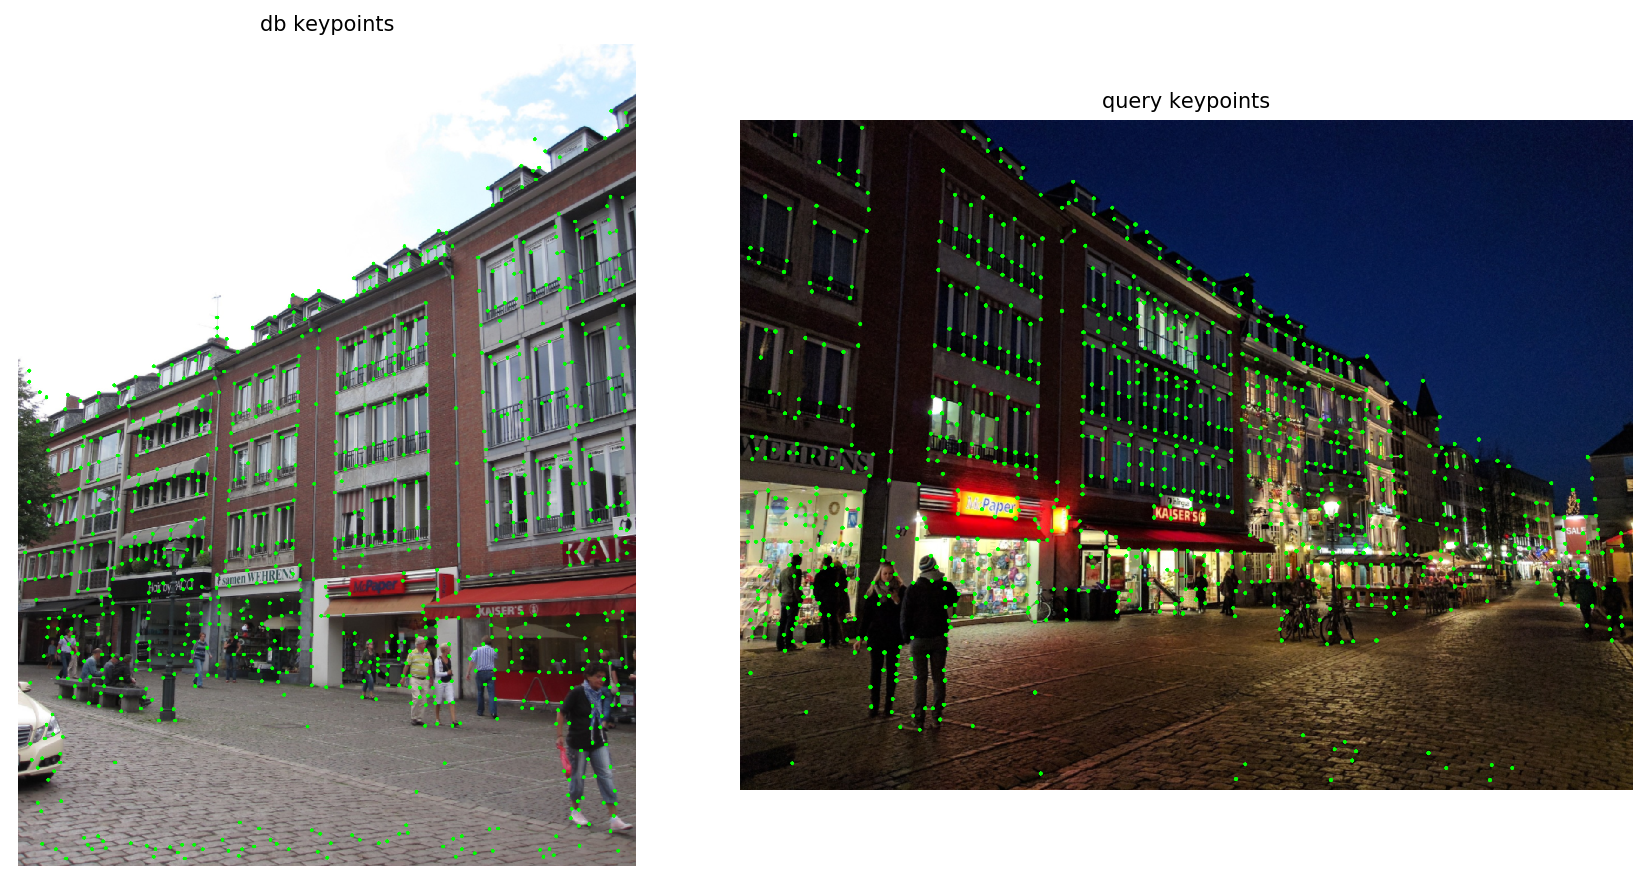

In [5]:
plot_images([draw_keypoints(im_db, pred_db['keypoints'], s=2, radius=4),
             draw_keypoints(im_query, pred_query['keypoints'], s=2, radius=4)],
            titles=['db keypoints', 'query keypoints'], dpi=150)

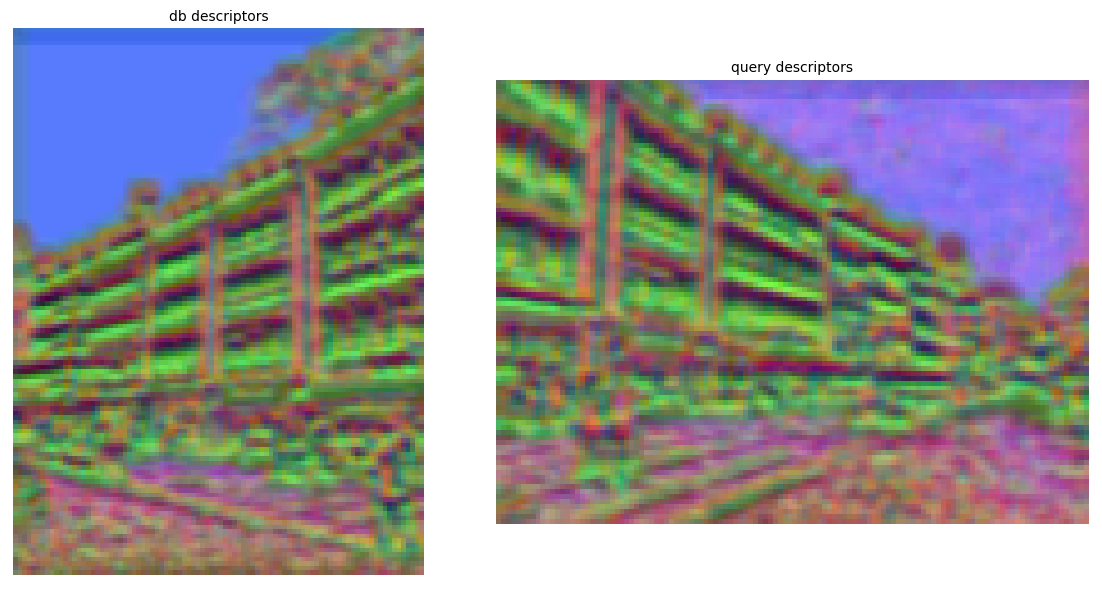

In [7]:
plot_images(draw_dense_descriptors(pred_db['local_descriptor_map'], pred_query['local_descriptor_map']),
            titles=['db descriptors', 'query descriptors'])

In [8]:
matches, dist = matching(pred_query['local_descriptors'], pred_db['local_descriptors'], do_ratio_test=True)
matches = matches[dist < 0.85]

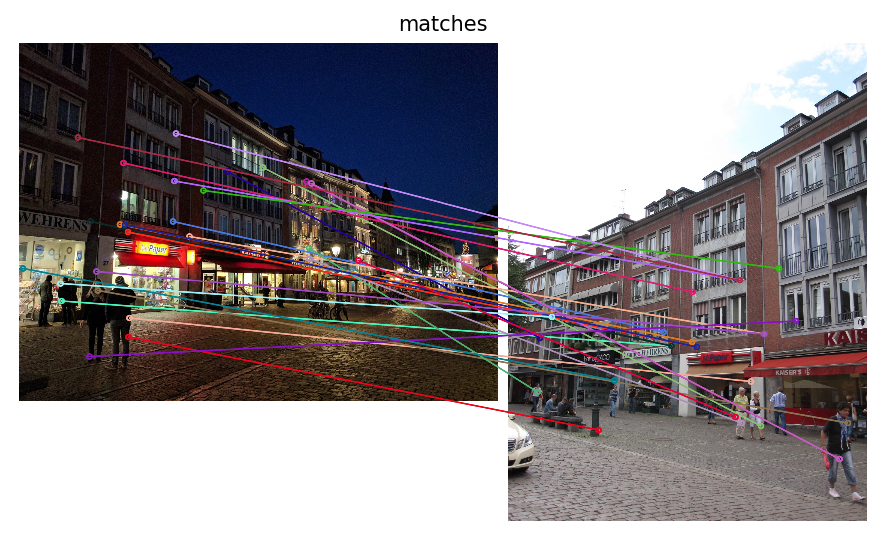

In [9]:
plot_images([draw_matches(im_query, pred_query['keypoints'], im_db, pred_db['keypoints'], matches)],
            titles=['matches'], dpi=150)